<a href="https://colab.research.google.com/github/yustinaivanova/netology_statistics/blob/master/lecture_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Кейс-стади -2. Определение СПАМа в тексте

In [0]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import pearsonr
%matplotlib inline

Датасет для определения СПАМа в тексте.

In [90]:
url='http://yustiks.ru/dataset/SPAM_text.csv'
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')))
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
data["Category"] = [1 if each == "spam" else 0 for each in data["Category"]]

In [92]:
data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Как на основе текста предсказать, что он является СПАМом? 

# Словарь BAG-of-words. 

Создаем слова. На основе слов пишем для каждого текста словарь, где каждое слово - это ключ, а значение ключа - это сколько раз встречается данное слова в данном тексте.

Как пример: рассмотрим 1 строку из датасета.



*   Удалим все символы, не являющимися латинскими буквами
*   Заглавные буквы меняем на строчные
*   Разделим текст на слова
*   В каждом слове выделяем корень слова
*   Создаем список всех слов



In [93]:
import re
nlp_data = str(data.loc[2, 'Message'])
print(nlp_data)

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


Удаление всех не латинских букв:

In [94]:
nlp_data = re.sub("[^a-zA-Z]"," ",nlp_data)
print(nlp_data)

Free entry in   a wkly comp to win FA Cup final tkts   st May       Text FA to       to receive entry question std txt rate T C s apply            over   s


Во всех словах заглавные буквы меняем на строчные

In [95]:
nlp_data = nlp_data.lower()
print(nlp_data)

free entry in   a wkly comp to win fa cup final tkts   st may       text fa to       to receive entry question std txt rate t c s apply            over   s


Переводим текст в отдельные слова

In [96]:
import nltk as nlp
nlp.download('punkt')
nlp_data = nlp.word_tokenize(nlp_data)
print(nlp_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']


Ищем корень каждого слова

In [97]:
nlp.download('wordnet')
lemma = nlp.WordNetLemmatizer()
nlp_data = [lemma.lemmatize(word) for word in nlp_data]
print(nlp_data)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']


Добавляем все найденные слова в список

In [0]:
nlp_data = " ".join(nlp_data)

In [0]:
description_list = []
for description in data["Message"]:
    description = re.sub("[^a-zA-Z]"," ",description)
    description = description.lower()
    description = nlp.word_tokenize(description)
    lemma = nlp.WordNetLemmatizer()
    description = [ lemma.lemmatize(word) for word in description]
    description = " ".join(description)
    description_list.append(description)

Создаем bag-of-words, для этого выбираем 3000 максимально встречаемых слов

In [100]:
from sklearn.feature_extraction.text import CountVectorizer 
max_features = 3000
count_vectorizer = CountVectorizer(max_features = max_features, stop_words = "english")
sparce_matrix = count_vectorizer.fit_transform(description_list).toarray()
print("Самые часто встречаемые {} слов: {}".format(max_features,count_vectorizer.get_feature_names()))

Самые часто встречаемые 3000 слов: ['aah', 'aathi', 'abi', 'ability', 'abiola', 'abj', 'able', 'absolutly', 'abt', 'abta', 'aburo', 'ac', 'academic', 'acc', 'accept', 'access', 'accident', 'accidentally', 'accordingly', 'account', 'ache', 'acl', 'aco', 'acted', 'acting', 'action', 'activate', 'active', 'activity', 'actor', 'actual', 'actually', 'ad', 'adam', 'add', 'addamsfa', 'added', 'addicted', 'addie', 'address', 'admin', 'administrator', 'admirer', 'admit', 'adore', 'adoring', 'adult', 'advance', 'adventure', 'advice', 'advise', 'ae', 'aeronautics', 'aeroplane', 'affair', 'affection', 'afraid', 'aft', 'afternoon', 'aftr', 'ag', 'agalla', 'age', 'agent', 'ago', 'agree', 'ah', 'aha', 'ahead', 'ahmad', 'aid', 'aight', 'ain', 'aint', 'air', 'airport', 'airtel', 'aiya', 'aiyah', 'aiyar', 'aiyo', 'aj', 'aka', 'al', 'alaipayuthe', 'album', 'alcohol', 'alert', 'alex', 'alfie', 'algarve', 'ali', 'alive', 'allah', 'allow', 'allowed', 'alright', 'alrite', 'alwys', 'amazing', 'american', 'amp

Исходные данные преобразуем в bag-of-words формат

In [101]:
sparce_matrix[:4]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [0]:
y = data.iloc[:,0].values
x = sparce_matrix

Делим данные на тренировочные и тестовые

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state = 42)

Напишем наивный баесовский классификатор

# Баесовский метод решения классификационной проблемы.

Лучшим другом аналитика данных является теорема Байеса4, которая позволяет "переставить" условные вероятности местами. Пусть нужно узнать вероятность не коего события E, зависящего от наступления некоего другого события F, причем в наличии имеется лишь информация о вероятности события F, зависящего от наступления события E. Двукратное применение (в силу симметрии) определения условной вероятности даст формулу Байеса:


$$ P(A\mid B) = \frac{P(B\mid A) P(A)}{P(B)}$$

где $P(A\mid B)$ - вероятность наступления события A при условии наличия события B


Если событие B разложить на два взаимоисключающих события B при условии A и B при условии $\bar{E}$, то событие P(B) можно представить как сумма вероятностей наступления событий $P(B\mid A)$ и  $P(B\mid \bar{A})$, тогда формула вероятности примет вид:

$$P(A\mid B) = \frac{P(B\mid A) P(A)}{P(B\mid A)P(A) + P(B\mid \bar{A})P(\bar{A})}$$


Если события независимы:

$$P(A\mid B) = P(A)P(B)$$

Если события зависимы, и при этом вероятность B не равна нулю, то 

$$P(A\mid B) = \frac{P(A, B) }{P(B)}$$


Под этим подразумевается вероятность наступления события A при условии, что известно о наступлении события B.

В случае независимости двух переменных формула принимает вид:

$$P(A\mid B) = P(A)$$


означает, что наличие наступления события B не дает нам никакой информации о наступлении события A

In [104]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train,y_train)
print("the accuracy of our model: {}".format(nb.score(x_test,y_test)))

the accuracy of our model: 0.8763440860215054


In [105]:
from sklearn.metrics import classification_report
print(classification_report(y_test, nb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.97      0.88      0.93       485
           1       0.52      0.84      0.64        73

    accuracy                           0.88       558
   macro avg       0.74      0.86      0.78       558
weighted avg       0.91      0.88      0.89       558



Напишем логистическую регрессию

In [106]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 200)
lr.fit(x_train,y_train)
print("our accuracy is: {}".format(lr.score(x_test,y_test)))

our accuracy is: 0.9767025089605734


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [107]:
print(classification_report(y_test, lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       485
           1       1.00      0.82      0.90        73

    accuracy                           0.98       558
   macro avg       0.99      0.91      0.94       558
weighted avg       0.98      0.98      0.98       558



Классификатор по методу ближайшего соседа

In [108]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train,y_train)
#print('Prediction: {}'.format(prediction))
print('With KNN (K=3) accuracy is: ',knn.score(x_test,y_test))

With KNN (K=3) accuracy is:  0.942652329749104


In [109]:
print(classification_report(y_test, knn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       485
           1       1.00      0.56      0.72        73

    accuracy                           0.94       558
   macro avg       0.97      0.78      0.84       558
weighted avg       0.95      0.94      0.94       558



Из всех выбранных моделей лучше всего дала результаты модель логистической регрессии.

# Анализ текста на тональность

Рассмотрим датасет twitter sentiment analyses hatred speach https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech#train.csv

In [110]:
url='http://yustiks.ru/dataset/twitter_train.csv'
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')))
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Есть колонка label - класс 1 означает, что текст содержит в себе ненависть и расизм. 0 - текст нейтрален по теме.

Задача - определить класс, к которому относится тот или иной текст

Удаляем слова, которые не имеют смысловой нагрузки (например, слова 'и', 'или', 'а' и другие)

In [111]:
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
import string
import re
stop_words = set(stopwords.words('english'))


def remove_stopwords(line):
    word_tokens = word_tokenize(line)
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return " ".join(filtered_sentence)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Далее функция, с помощью которой мы будем обрабатывать твиты


*   переводим все слова в строчные буквы
*   удаляем цифры
*   удаляем пунктуацию
*   удаляем стоп-слова



In [0]:
def preprocess(line):
  # все слова переводим в строчный текст
    line = line.lower()
  # удаляем цифры
    line = re.sub(r'\d+', '', line)
  # удаляем пунктуацию
    line = line.translate(line.maketrans("","", string.punctuation))
    line = remove_stopwords(line)
    return line


Предобработка всех твитов из таблицы

In [113]:
train = data

for i,line in enumerate(train.tweet):
    train.tweet[i] = preprocess(line)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Разделим датасет на тренировочный и тестовый

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train['tweet'], train['label'], test_size=0.5, stratify=train['label'])

trainp=train[train.label==1]
trainn=train[train.label==0]
print(trainp.info())
trainn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2242 entries, 13 to 31960
Data columns (total 3 columns):
id       2242 non-null int64
label    2242 non-null int64
tweet    2242 non-null object
dtypes: int64(2), object(1)
memory usage: 70.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29720 entries, 0 to 31961
Data columns (total 3 columns):
id       29720 non-null int64
label    29720 non-null int64
tweet    29720 non-null object
dtypes: int64(2), object(1)
memory usage: 928.8+ KB


Можно заметить, что классы **несбалансированы**: в классе 1 2242 элемента, а в классе 0 их 29720. 

Создадим bag-of-words вектора для всех твитов

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect = CountVectorizer()
tf_train=vect.fit_transform(X_train)  #train the vectorizer, build the vocablury
tf_test=vect.transform(X_test)  #get same encodings on test data as of vocabulary built

Создадим модель **Наивный баес**

In [0]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

Обучим модель

In [117]:
model.fit(X=tf_train,y=y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Посмотрим качество модели

In [118]:
expected = y_test
predicted=model.predict(tf_test)
from sklearn import metrics

print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     14860
           1       0.90      0.43      0.58      1121

    accuracy                           0.96     15981
   macro avg       0.93      0.71      0.78     15981
weighted avg       0.95      0.96      0.95     15981

[[14807    53]
 [  643   478]]


Можно заметить, что класс 1 предсказывается намного хуже, чем класс 0: класса 1 намного меньше по числу элементов, чем класс 0.

Сбалансируем датасет

In [119]:
train_imbalanced = train
from sklearn.utils import resample
df_majority = train[train.label==0]
df_minority = train[train.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
print("Before")
print(train.label.value_counts())
print("After")
print(df_upsampled.label.value_counts())

X_train, X_test, y_train, y_test = train_test_split(df_upsampled['tweet'], df_upsampled['label'], test_size=0.5, stratify=df_upsampled['label'])

Before
0    29720
1     2242
Name: label, dtype: int64
After
1    29720
0    29720
Name: label, dtype: int64


Можно заметить, что тренировочных данных стало больше, и классы уравнялись в количестве.

In [120]:
tf_train=vect.fit_transform(X_train)
tf_test=vect.transform(X_test)
model.fit(X=tf_train,y=y_train)
expected = y_test
predicted=model.predict(tf_test)
from sklearn import metrics

print(metrics.classification_report(expected, predicted))
print('Матрица confusion')
print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     14860
           1       0.92      0.98      0.95     14860

    accuracy                           0.95     29720
   macro avg       0.95      0.95      0.95     29720
weighted avg       0.95      0.95      0.95     29720

Матрица confusion
[[13599  1261]
 [  259 14601]]


Можно заметить, что балансировка привела к улучшению результата.

# Анализ временного ряда

In [136]:
url="http://yustiks.ru/dataset/BrentOilPrices.csv"
df=pd.read_csv(url)
df.tail()

,Date,Price
8211,"Sep 24, 2019",64.13
8212,"Sep 25, 2019",62.41
8213,"Sep 26, 2019",62.08
8214,"Sep 27, 2019",62.48
8215,"Sep 30, 2019",60.99


In [137]:
df['Date'] = pd.to_datetime(df['Date'], format="%b %d, %Y")
df.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [138]:
len(df)

8216

Всего дано 8216 дней.

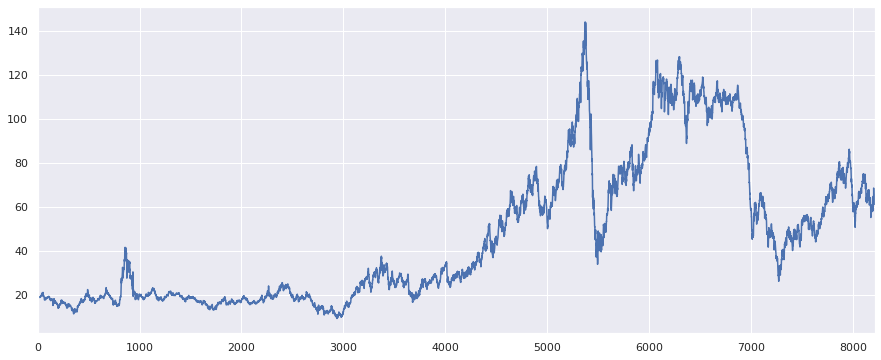

In [140]:
df.Price.plot(figsize=(15, 6))
plt.show()

Нормализуем данные

In [0]:
# normalize the data_set 
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
df_normalized = sc.fit_transform(np.array(df.Price).reshape(-1, 1))

In [178]:
# Разобъем данные по 30 дней. Возьмем данные только за последние 2 года
df_normalized = df_normalized[-2*365:].reshape(1, -1)[0].T
len(df_normalized)

730

In [179]:
df_normalized[0]

0.26303299962921767

In [180]:
X_input = []
Y_input = []
for i in range(len(df_normalized) - 30 - 1):
  X_input.append(df_normalized[i:i+30])
  Y_input.append(df_normalized[i+31])
print(len(X_input))
print(len(Y_input))

699
699


X_input - все возможные комбинации тридцати дней за последние 2 года

Y_input - то, что следует на следующий день по завершении этих 30-ти дней.

In [0]:
data_transposed = zip(X_input, Y_input)
data = pd.DataFrame(data_transposed, columns=["X", "Y"])

Таким образом, мы решаем **проблему регрессии**: есть некий вектор X - это 30 дней, когда предсказания известны. И есть вектор Y - это один день, который идет сразу же за этими 30тью днями

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_input,
    Y_input,
    test_size = 0.2,
    random_state = 3
)

In [193]:
print(X_train[0])
print(y_train[0])

[0.29922136 0.29862811 0.30322581 0.29929551 0.29929551 0.30634038
 0.29818317 0.2945495  0.28498331 0.28439006 0.27816092 0.28149796
 0.28913608 0.29721913 0.29647757 0.31286615 0.3122729  0.3163515
 0.31598072 0.32391546 0.32814238 0.32695588 0.32769744 0.31998517
 0.30952911 0.31998517 0.30812013 0.29885057 0.30634038 0.29187987]
0.289284390063033


Попробуем решить **линейной регрессией**

In [194]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9700559019238674

Неплохой результат для начала. 

Посмотрим предсказания для 13 элементов из тестового датасета.

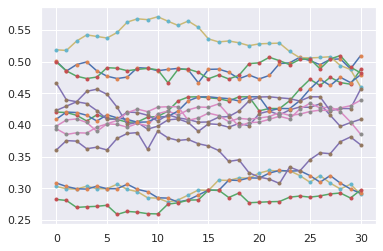

In [208]:
y_predict = model.predict(X_test)
x_line = np.array([i for i in range(0, 31)])
for j in range(13):
  y_line = np.hstack((X_test[j], y_test[j])) 
  plt.plot(x_line, y_line)
  y_line_predicted = np.hstack((X_test[j], y_predict[j]))
  plt.plot(x_line, y_line, '.')
plt.show()

Таким образом, мы довольно точно предсказываем прогноз на следующий день после 30 дней известных показаний.

Зная результат на следующий день, мы можем предсказать, что будет через день после предсказанного результата: для этого мы предсказания используем в качестве X данных, удаляется первый день предсказаний, и кладется последний предсказанный результат в X вектор

Пример: возьмем первый элемент (его номер 0). Предсказание для этой последовательности дней становится последним элементов в x векторе. Ищем предсказание для нового вектора теперь.


In [0]:
X_new = np.hstack((X_test[0][1:], y_predict[0]))

In [221]:
print(X_new)

[0.48505747 0.49529106 0.49944383 0.48527994 0.47690026 0.47319244
 0.47556544 0.49039674 0.48950686 0.48557657 0.48765295 0.48921023
 0.48698554 0.46659251 0.4877271  0.48809789 0.4831294  0.47289581
 0.47882833 0.47252503 0.47816092 0.49677419 0.49803485 0.50678532
 0.50137189 0.49514275 0.50344828 0.50418984 0.48854283 0.48514227]


In [226]:
model.predict(X_new.reshape(1, -1))

array([0.48443785])

Как нормированные данные перевести в цифру, которую мы хотим предсказать?

In [230]:
sc.inverse_transform(X_new.reshape(1, -1))

array([[74.51      , 75.89      , 76.45      , 74.54      , 73.41      ,
        72.91      , 73.23      , 75.23      , 75.11      , 74.58      ,
        74.86      , 75.07      , 74.77      , 72.02      , 74.87      ,
        74.92      , 74.25      , 72.87      , 73.67      , 72.82      ,
        73.58      , 76.09      , 76.26      , 77.44      , 76.71      ,
        75.87      , 76.99      , 77.09      , 74.98      , 74.52143452]])

# LSTM - рекурентная нейросеть для предсказаний временного ряда.